In [1]:
import os # ADDED THIS LINE
os.environ['JAX_PLATFORMS'] = 'cpu' # ADDED THIS LINE

import jax
import jax.numpy as jnp
from flax.training import train_state
import optax
import mujoco
from mujoco import mjx
from typing import Callable, Dict
from jax import Array

# from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sysidmjx.core import generate_loss_train_functions, get_batch
from sysidmjx.assets.single_motor.dataloader.single_joint import data_load
from jax import config

config.update("jax_debug_nans", True)
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_default_matmul_precision", "high")


class PARAMS:
    SEED = jax.random.PRNGKey(2)
    EXPERIMENT_NAME = "test"

    class DATASET:
        PATH = "datasets/generated/test.csv"
        DT = 0.001
        motor_id = 3
        num_lags = 5

    class SIM:
        PATH = "assets/single_motor/model/single_motor.xml"
        INTEGRATOR = mujoco.mjtIntegrator.mjINT_EULER
        # INTEGRATOR = mujoco.mjtIntegrator.mjINT_RK4
        ITERATIONS = 1

    class TRAIN:
        EPOCH_NUM = 10 # WAS 300
        # BATCH_NUM = 5*6
        BATCH_SIZE = 200 # WAS 20000
        LEARNING_RATE = 1e-2
        TX = optax.adam(LEARNING_RATE)

    # class MODEL:
    #     NUM_HIST_LAGS = 5

Failed to import warp: No module named 'warp'
Failed to import mujoco_warp: No module named 'warp'


# Upload data

In [2]:
dataset, df =data_load(
    data_path=PARAMS.DATASET.PATH,
    motor_id=PARAMS.DATASET.motor_id,
    num_lags=PARAMS.DATASET.num_lags,
)

# Setup model

In [3]:
mj_model = mujoco.MjModel.from_xml_path(PARAMS.SIM.PATH)
mj_model.opt.timestep = PARAMS.DATASET.DT
mj_model.opt.iterations = PARAMS.SIM.ITERATIONS
mj_model.opt.integrator = PARAMS.SIM.INTEGRATOR
mj_data = mujoco.MjData(mj_model)

mjx_model = mjx.put_model(mj_model)
mjx_data = mjx.put_data(mj_model, mj_data)
print(f"integrator:{mj_model.opt.integrator}")
print(f"timestep:{mj_model.opt.timestep}")
print(f"iterations:{mj_model.opt.iterations}")

integrator:0
timestep:0.001
iterations:1


# Identify parameters and function they use

In [4]:
# Generate random keys for initialization
keys = jax.random.split(PARAMS.SEED, num=5)

# Define initial parameters for the model (set to zeros initially)
zero_params = {
    "armature": jnp.array([0.0]),
    "frictionloss": jnp.array([0.0]),
    "damping": jnp.array([0.0]),
}

# Define parameters for model initialization, randomly sampled within specific ranges
init_params = {
    "armature": jax.random.uniform(keys[2], maxval=0.001, shape=(1,)),  # Random armature between 0 and 0.001
    "frictionloss": jax.random.uniform(keys[3], maxval=0.01, shape=(1,)),  # Random friction loss between 0 and 0.01
    "damping": jax.random.uniform(keys[4], maxval=0.01, shape=(1,)),  # Random damping between 0 and 0.01
}


@jax.jit
def change_model(params:Dict, old_model:mjx.Model):
    """
    Modify the existing model by updating its parameters (armature, friction loss, damping).
    
    Args:
        params (dict): The parameters used to modify the model (armature, frictionloss, damping).
        old_model (mjx.Model): The old model instance to be updated.
    
    Returns:
        changed_model (mjx.Model): The updated model with new parameter values.
    """
    # Create a new model by replacing certain parameters with updated ones.
    changed_model = old_model.replace(
        # If needed, actuator gains or biases can be modified here
        # actuator_gainprm=actuator_gainprm,
        # actuator_biasprm=actuator_biasprm,
        
        # Replace parameters in the model with absolute values to ensure no negative values
        dof_armature=abs(params["armature"]),
        dof_frictionloss=abs(params["frictionloss"]),
        dof_damping=abs(params["damping"]),
    )
    
    return changed_model


@jax.jit
def make_action(params:Dict, data:mjx.Data, ctrl:Array):
    """
    Computes the control action (torque) based on the position error and velocity error.
    
    Args:
        params (Dict): The parameters used in the action calculation (e.g., friction loss).
        data (mjx.Data): The current state data of the system (position and velocity).
        ctrl (Array): The desired control input.
    
    Returns:
        tau (Array): The calculated torque based on proportional-derivative control law.
    """
    kp = 20  # Proportional gain
    kv = 1   # Derivative gain
    
    # Calculate the torque based on position and velocity errors
    tau = kp * (ctrl - data.qpos) - kv * data.qvel
    
    # Uncomment to apply friction-based torque adjustment
    # fric = jnp.sign(data.qvel) * abs(params["frictionloss"])
    # tau = tau - fric
    
    return tau


# Generate total loss and training step functions by passing the model, data, change_model, and action functions
total_loss, train_step, _ = generate_loss_train_functions(
    mjx_model=mjx_model,        # The model used in training
    mjx_data=mjx_data,          # The data used during training
    change_model=change_model,  # Function to modify the model during training
    make_action=make_action,    # Function to compute actions during training
)


# Training loop

In [5]:
state = train_state.TrainState.create(
    apply_fn=None,
    params=init_params,
    tx=PARAMS.TRAIN.TX,
)

loss_hist = []
params_hist = []
indxs = jax.numpy.array(range(dataset["qpos"].shape[0]))

for epoch in range(PARAMS.TRAIN.EPOCH_NUM):
    # VALIDATE
    loss = total_loss(
        state.params,
        qpos=dataset["qpos"],
        qvel=dataset["qvel"],
        ctrl_vec=dataset["qact"],
        qpos_des=dataset["qpos_next"],
    )
    loss_hist.append(loss)
    print(f"Epoch {epoch}, Loss: {loss}")

    params_hist.append(state.params)
    # TRAIN
    batch, indxs = get_batch(dataset, PARAMS.SEED, indxs, PARAMS.TRAIN.BATCH_SIZE)
    state, grads = train_step(
        state,
        qpos=batch["qpos"],
        qvel=batch["qvel"],
        ctrl_vec=batch["qact"],
        qpos_des=batch["qpos_next"],
    )

Epoch 0, Loss: 3.7901515973945867e-06
Epoch 1, Loss: 3.0138488690581564e-06
Epoch 2, Loss: 2.973978806894137e-06
Epoch 3, Loss: 2.9652421271743596e-06
Epoch 4, Loss: 2.96284988488797e-06
Epoch 5, Loss: 2.9622268389401743e-06
Epoch 6, Loss: 2.9622716936819184e-06
Epoch 7, Loss: 2.9625478270092098e-06
Epoch 8, Loss: 2.962912528248893e-06
Epoch 9, Loss: 2.9632981983750028e-06


# Loss Analysis

In [6]:
baseline_loss = total_loss(
    zero_params,
    qpos=dataset["qpos"],
    qvel=dataset["qvel"],
    ctrl_vec=dataset["qact"],
    qpos_des=dataset["qpos_next"],
)
adjusted_model_loss = np.array(loss_hist)
base_line = np.ones_like(adjusted_model_loss)

/tmp/ipykernel_837437/98343391.py:51: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


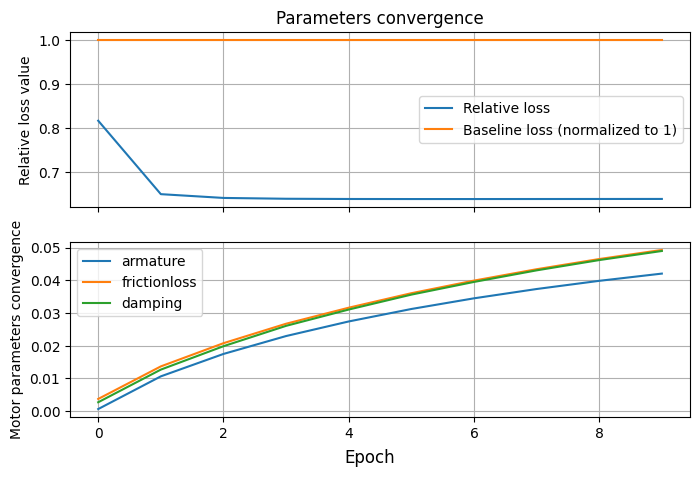

In [7]:
import matplotlib.pyplot as plt
import os, joblib

# Create a figure and gridspec with custom height ratios
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(8, 5), gridspec_kw={"height_ratios": [1, 1]}, sharex=True
)
# fig, ax1 = plt.subplots(1, 1, figsize=(8, 4.5))

# # Plot on the first (larger) subplot
ax1.plot(adjusted_model_loss / baseline_loss, label="Relative loss")
ax1.plot(base_line, label="Baseline loss (normalized to 1)")
ax1.set_title("Parameters convergence")
ax1.set_ylabel("Relative loss value")
ax1.legend()
ax1.grid(True)

# Plot on the second (smaller) subplot
ax2.plot([p["armature"] for p in params_hist], label="armature")
ax2.plot([p["frictionloss"] for p in params_hist], label="frictionloss")
ax2.plot([p["damping"] for p in params_hist], label="damping")
ax2.set_ylabel("Motor parameters convergence")
ax2.legend()
ax2.grid(True)

# Set a shared x-axis label
fig.supxlabel("Epoch")
# fig.supylabel('Y-axis')


folder_path = os.path.join("assets/experiments", PARAMS.EXPERIMENT_NAME)
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
img_path = os.path.join(folder_path, "pictures")
if not os.path.exists(img_path):
    os.makedirs(img_path)
joblib.dump(
    {
        "params": params_hist,
        "loss_hist": adjusted_model_loss,
        "baseline_loss": baseline_loss,
    },
    os.path.join(folder_path, "otimization_info.joblib"),
)

fig.savefig(
    os.path.join(img_path, "loss.png"),
    format="png",
    bbox_inches="tight",
)
fig.show()